In [1]:
from final_2016 import pass_data
from graph_util import *

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import copy
from scipy.special import expit
from torch import cholesky

import torch

import pyro
import pyro.distributions as dist

from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import pyplot
from statsmodels.graphics.regressionplots import abline_plot

from collections import defaultdict
import seaborn as sns

import plotnine as p9
from plotnine import *
from tqdm.notebook import tqdm

import dill

## Goals

Our goals are two-fold:
  1. is to translate The Economist's presidential election prediction model from R & Stan to Python & Pyro
  2. is to do a thorough evaluation of the results generated by the model and inference methods we have translated from the previous goal

## Model

#### Abramovitz "Time for Change" Model

A common critisim for Fundamental Models as explained by Economist is that they provide a close match to historical data and thus fail to capture the future given the current election polling data

national_mu_prior = $x_0 + x_1 \cdot \text{juneapp} + x_2 \cdot \text{q2gdp}$

juneapp - June approval rating of Incumbent <br/> 
q2gdp - 2nd quarter GDP of election year <br/>

data - values being passed for the bayesian model<br/>
polls - point estimates for a democrat to win a state<br/>
res - ordinary least square results for abramovitz 'time-for-change' model<br/>
abramovitz - data used for regression plot<br/>
ev - electoral vote dictionary 

In [3]:
data, polls, res, abramovitz, ev = pass_data()

The Abramovitz OLS prediction results in a linear model that is entirely encapsulated by the variables described above and historically does a good job in predicting an election winner; however, it does not totally capture current polling sentiments and both we (and The Economist) believe that the true probability space describing election result winners is comprised of both the fundamental Abramowitz model and polling data.

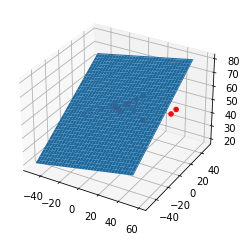

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(abramovitz['juneapp'], abramovitz['q2gdp'], abramovitz['incvote'], c='r', marker='o')

coefs = res.params
xs = np.tile(np.arange(101), (101,1)) - 50
ys = np.tile(np.arange(101), (101,1)).T - 50
national_mu_prior =  coefs["Intercept"] + coefs["juneapp"] * xs + coefs["q2gdp"] * ys

ax.plot_surface(xs,ys,national_mu_prior)
plt.show()

### Dynamic Bayesian Model w. Polling & Abramovitz Data

- The Bayesian network relates the abramovitz and polling data over adjacent time steps until the election

$y_i^d \sim Binom(n_i, \pi_{i,j}^d)$ 

$logit(\pi_{i,j}^d) = \mu_b[t,s] + Bias(pollster, state\ population, poll\ mode, measuring)$

where, <br />
&nbsp;&nbsp; $y_i^d$ - no of dem. supportors <br />
&nbsp;&nbsp; $n_i$ - Total responders to poll <br />
&nbsp;&nbsp; $\pi_{i,j}^d$ - share of dem votes <br />
&nbsp;&nbsp; $\mu_b[t,s]$ - s state component on day t

- It uses the Abramovitz model prediction as the prior for the $\mu_b$ values and uses reverse random walk to relate over time with polls

$\mu_b[t-1, s] \sim Normal(\mu_b[t,s]) $

As a result the election day prediction is given by
$logit^{-1}(\mu_b[t,s])$

In [5]:
from poll_model import model, Inference_MCMC, sample_posterior_predictive, predicted_score

### Inference

Here we are using the pass_data( ) function from our final_2016.py helper python file in order to abstract the extensive & dull data preprocessing needed before feeding into the model. We use the NUTS paradigm to help explore our vast data set in a more efficient manner; otherwise we would not be able to tractably estimate the posterior. 

In [6]:
numSamples = 500
numChains = 6

In [7]:
posterior_samples, hmc_samples = Inference_MCMC(model, data,
                                                polls, numSamples,
                                                numSamples, numChains)

### Posterior Predictive

This gives us the samples that are conditioned on the posterior distribution of the latent variable model so that we can extract the predicted variables such as mu_b and thereafter evaluate the model.

In [8]:
posterior_predictive = sample_posterior_predictive(model,
                                                   posterior_samples,
                                                   numSamples*numChains, data)

### Predicted Probability

Probability values from logits

In [9]:
predicted = predicted_score(posterior_predictive, numSamples*numChains, data)

In [10]:
vals = predicted[:,90,:]   #Day 90 (Can change from 0-251)

In [11]:
preds = createPredictionsDict(vals)

## Evaluation

Below we will display graphs showing the results that we have achieved from the model. We see that there is non optimal variability in the model predictions and that the model does not accurately predict the winner of the 2016 election. That is fine for us, because we were able to see the progression of the results over time and how the probability for Clinton to win a swing state varies over time and how far off our average guesses were from the true results.  Even more so, we see that at a high level the posterior follows the prior probabilities, but with a smaller standard deviation, and with average values that stay within 1 standard deviation of the prior probability’s average values. Overall, this gives us a probabilistic model that extrapolates from both fundamental and polling data that is statistically sound despite its occasional slip-ups.

In [12]:
swing_states = ["OH", "WI", "MI", "FL", "GA", "PA", "IA", "AZ"]
EV, EV_Index = ev["EV"], ev["EV_Index"]
numDays = len(preds[0])
numStates = len(preds)
EV_list_trump = list()
EV_list_clinton = list()


out = electoralVoteCalculator(numDays, numStates,
                        preds, EV_Index, EV)
cWins, tWins, EV_T, EV_C = out[0], out[1], out[2], out[3]

In [13]:
ind_list = [list(EV.keys()).index(s) for s in swing_states]

### Predicted probability for democrat winning in swing states

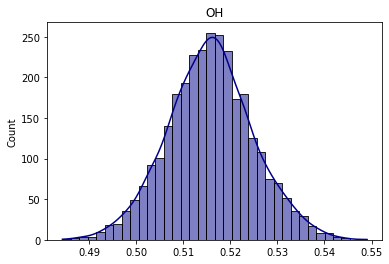

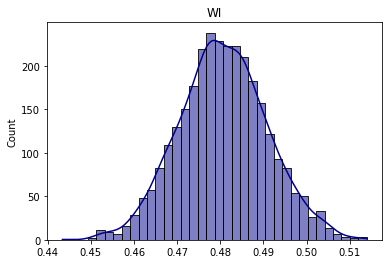

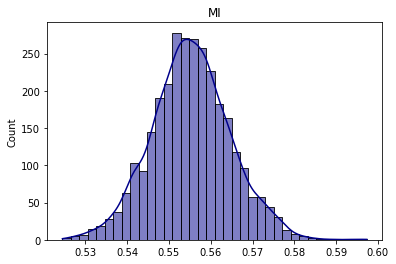

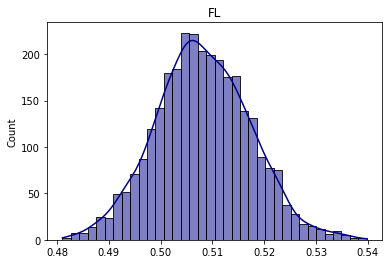

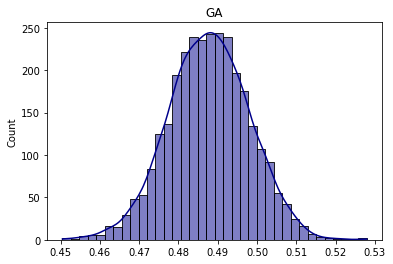

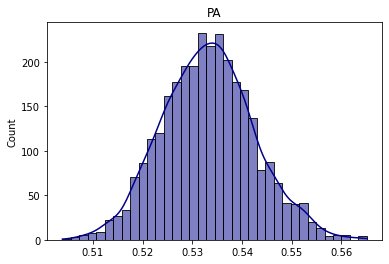

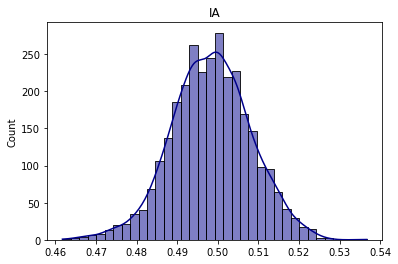

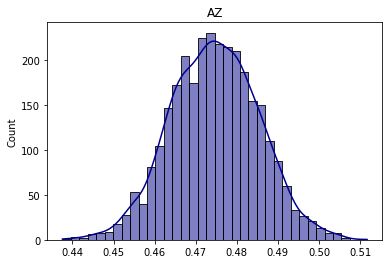

In [14]:
for i in ind_list:
    plt.figure()
    sns.histplot(np.array(preds[i]),kde=True, 
             bins=int(180/5), color = 'darkblue').set_title(EV_Index[i])

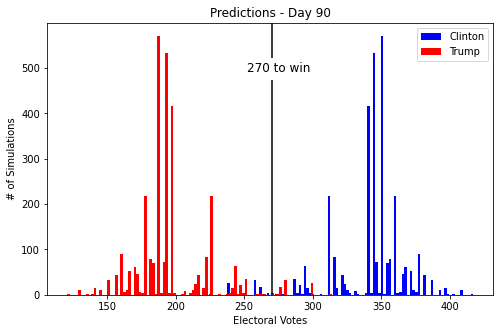

In [15]:
fig= plt.figure(figsize=(8,5))
plt.hist(EV_C, bins='auto', color = 'b')
plt.hist(EV_T, bins='auto', color = 'r')
plt.legend(['Clinton', 'Trump'])
plt.axvline(x=270, color='black', linestyle='-')
plt.text(252, numSamples, '270 to win', fontsize=12, va='center', ha='left', backgroundcolor='w')
plt.xlabel("Electoral Votes")
plt.ylabel("# of Simulations")
plt.title("Predictions - Day 90")
plt.show()

In [16]:
cWinsList, tWinsList = [], []
EV_C_mu, EV_T_mu = [], []
EV_C_std, EV_T_std = [], []

EV_C_mu, EV_C_std, EV_T_mu, EV_T_std, cWinsList, tWinsList =\
    generate_mu_sigma(EV_C_mu, EV_C_std, EV_T_mu, EV_T_std,
                      cWinsList, tWinsList, predicted, 
                      numDays, numStates, EV_Index, EV)

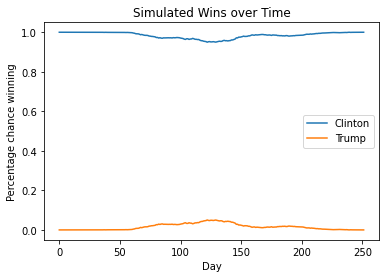

In [17]:
pct_clinton_win = [x/(x+y) for x, y in zip(cWinsList, tWinsList)]
pct_trump_win = [y/(x+y) for x, y in zip(cWinsList, tWinsList)]
sns.lineplot(data=np.array(pct_clinton_win))
sns.lineplot(data=np.array(pct_trump_win))
plt.legend(['Clinton', 'Trump'])
plt.xlabel("Day")
plt.ylabel("Percentage chance winning")
plt.title("Simulated Wins over Time")

plt.show()

The dark shade represents 1-standard deviation and the light shade represents 2-standard deviation

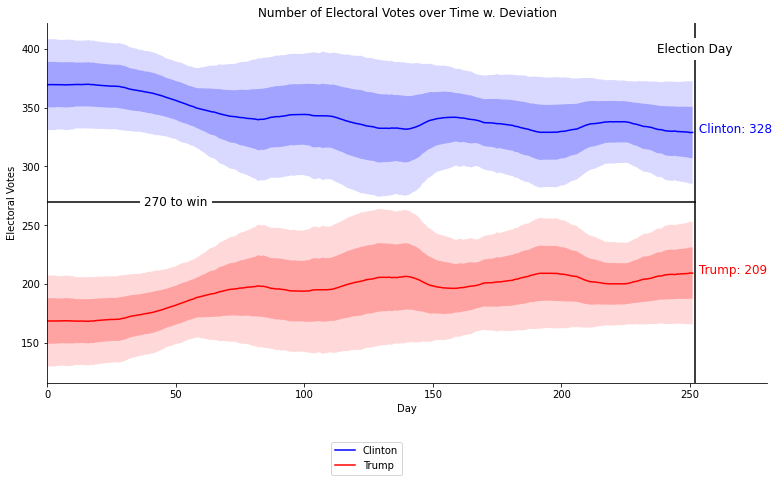

In [18]:
plot_ev_over_time(EV_C_mu, EV_C_std, EV_T_mu, EV_T_std)

In [19]:
states = list(EV.keys())

In [20]:
mu_b_prior = data['mu_b_prior']
state_covariance_mu_b_T = data['state_covariance_mu_b_T']
mu_b_prior_draws = np.random.multivariate_normal(mu_b_prior, state_covariance_mu_b_T, 1000)
mu_b_prior_df = mean_low_high(mu_b_prior_draws, states, 'prior')

In [21]:
mu_b_posterior_draws = posterior_predictive['mu_b'].squeeze()[:,:,-1]
mu_b_posterior_df = mean_low_high(mu_b_posterior_draws, states, 'posterior')
mu_b_posterior_df['prob'] = (expit(mu_b_posterior_draws)> 0.5).type(torch.float).mean(axis=0)
mu_b_posterior_df['color'] = mu_b_posterior_df['mean'].apply(lambda x: "Dem" if x>0.5 else "Rep")
color_dict={"Dem": "blue",
           "Rep": "red"}

idx = mu_b_posterior_df["states"].isin(swing_states)
mu_b_posterior_df[idx][['states', 'mean', 'high', 'low', 'prob']].reset_index().drop(columns=['index'])

,states,mean,high,low,prob
0,AZ,0.458922,0.475560,0.442375,0.000000
1,FL,0.504361,0.520300,0.488412,0.701667
2,GA,0.478491,0.494439,0.462585,0.004667
3,IA,0.492204,0.508366,0.476058,0.169667
4,MI,0.545685,0.561641,0.529635,1.000000
5,OH,0.504514,0.520394,0.488624,0.712000
6,PA,0.530745,0.546475,0.514953,1.000000
7,WI,0.482590,0.499383,0.465836,0.025333


In [22]:
mu_b_df = pd.concat([mu_b_prior_df, mu_b_posterior_df])

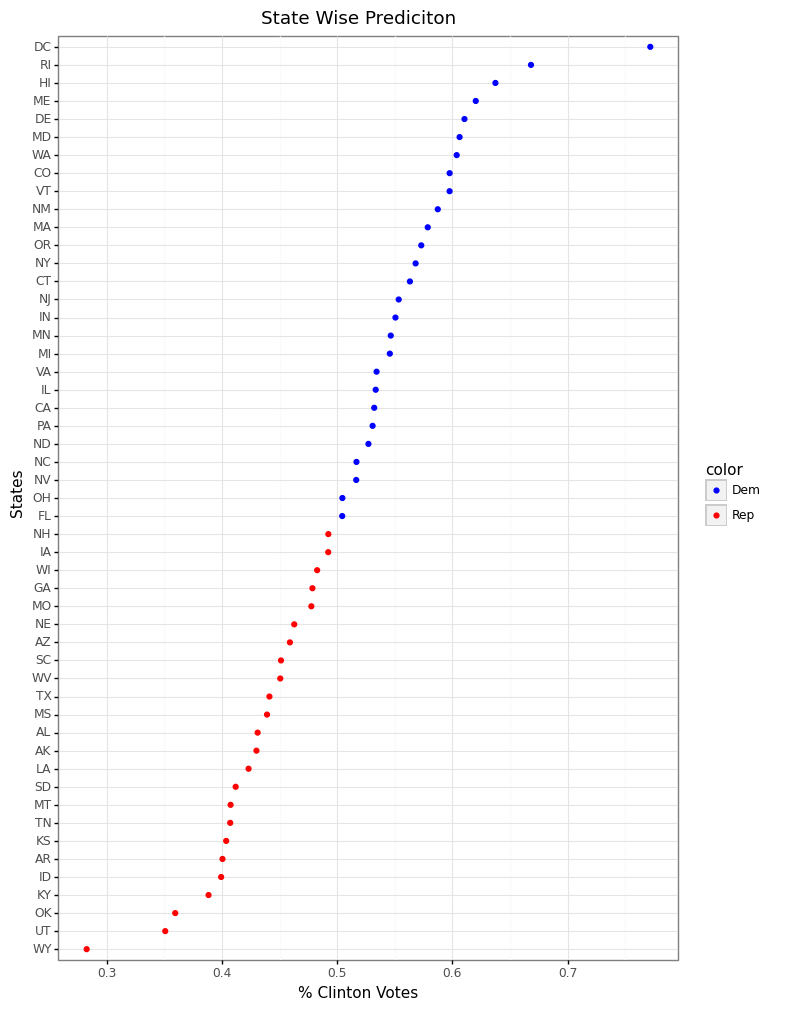

<ggplot: (329299851)>

In [23]:
p9.options.figure_size = (8, 12)
(
    ggplot(mu_b_posterior_df) +
    ggtitle("State Wise Prediciton")+
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='color'), position = position_dodge(width = 0.5)) +
    scale_color_manual(values=color_dict)+
    coord_flip() +
    theme_bw()+
    p9.labels.ylab("% Clinton Votes")+
    p9.labels.xlab("States")
 )

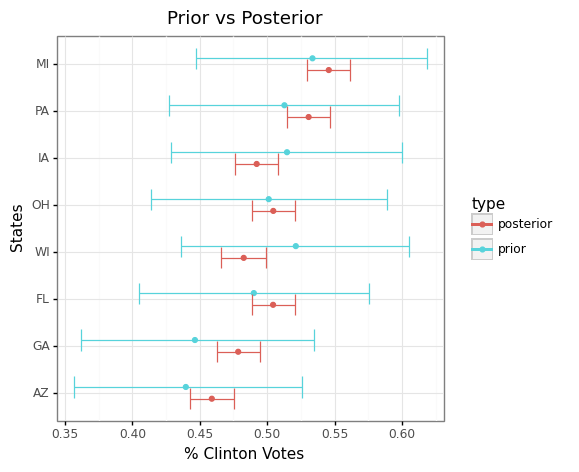

<ggplot: (329052206)>

In [24]:
idx = mu_b_df['states'].isin(swing_states)
p9.options.figure_size = (5, 5)
(
    ggplot(mu_b_df[idx]) +
    ggtitle("Prior vs Posterior")+
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type'), position = position_dodge(width = 0.5)) +
    geom_errorbar(aes(ymin = 'low', ymax = 'high', x = 'states', color='type'), width = 0, position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()+
    p9.labels.ylab("% Clinton Votes")+
    p9.labels.xlab("States")
 )

In [25]:
pct_clinton = function_tibble(0, predicted)
for i in range(1, predicted.shape[2]):
    temp = function_tibble(i, predicted)
    pct_clinton = pd.concat([pct_clinton, temp])
pct_clinton['state'] = pct_clinton['state'].apply(lambda x: states[x])

In [26]:
cols = ['state', 'year', 'dem']
results = pd.read_csv("../data/potus_results_76_16.csv", usecols=cols)
results = results.loc[results['year'] == 2016][['state','dem']].reset_index().drop(columns=['index'])
results = results.rename(columns={'state': 'states', 'dem':'mean'})
results['type'] = ['result']*len(states)

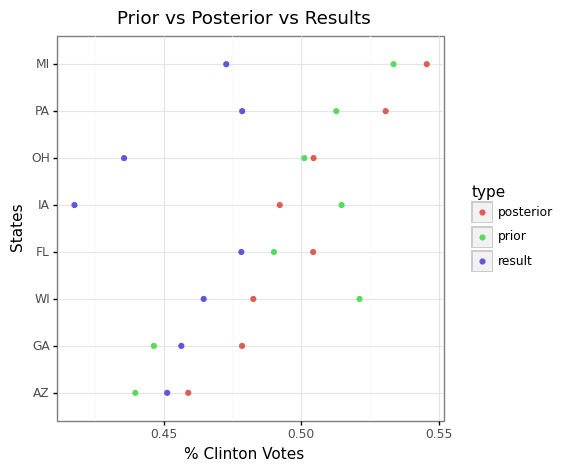

<ggplot: (329146465)>

In [27]:
df = pd.concat([results, mu_b_posterior_df, mu_b_prior_df])
idx = df['states'].isin(swing_states)

p9.options.figure_size = (5, 5)
(
    ggplot(df[idx]) +
    ggtitle("Prior vs Posterior vs Results")+
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type')) +
    coord_flip() +
    theme_bw()+
    p9.labels.ylab("% Clinton Votes")+
    p9.labels.xlab("States")
 )

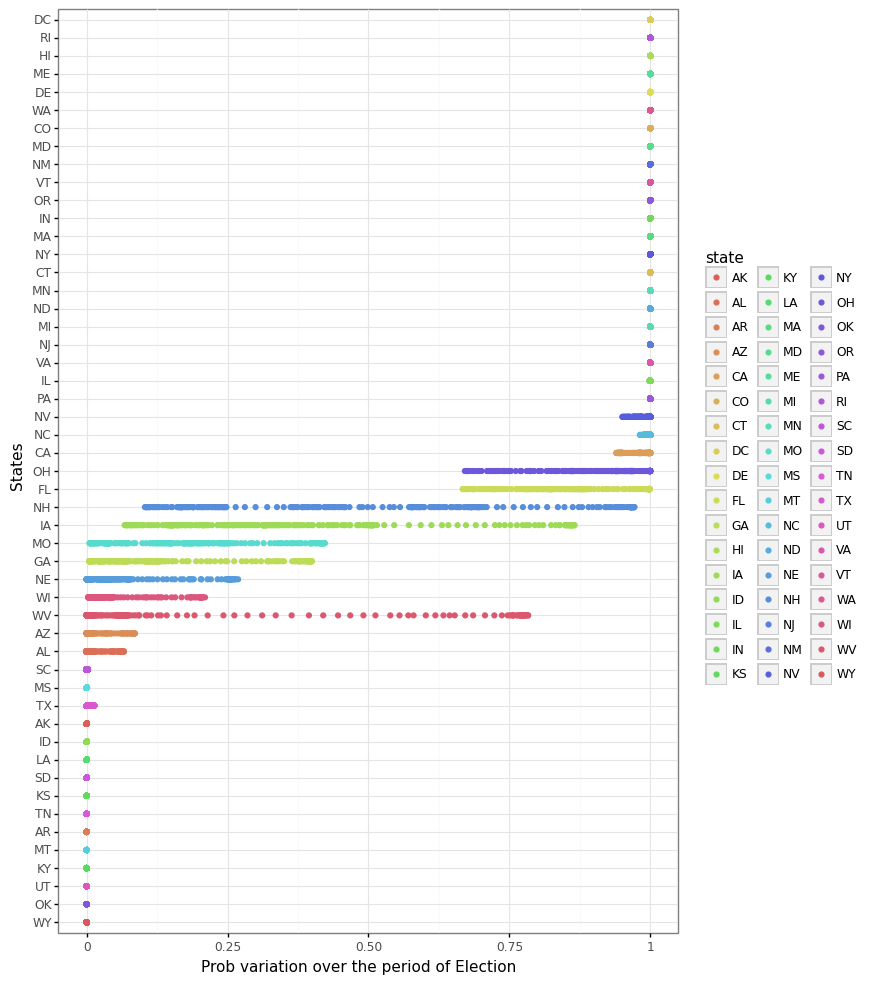

<ggplot: (329235460)>

In [28]:
p9.options.figure_size = (8, 12)
(
    ggplot(pct_clinton) +
    geom_point(aes(y = 'prob', x = 'reorder(state, mean)', color='state'), position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()+
    p9.labels.ylab("Prob variation over the period of Election")+
    p9.labels.xlab("States")
 )

### Posterior Predictive Check

In [29]:
obs = posterior_predictive['n_democrat_state'].squeeze()
y_true = polls['n_democrat_state']
n_polls = data['N_state_polls']

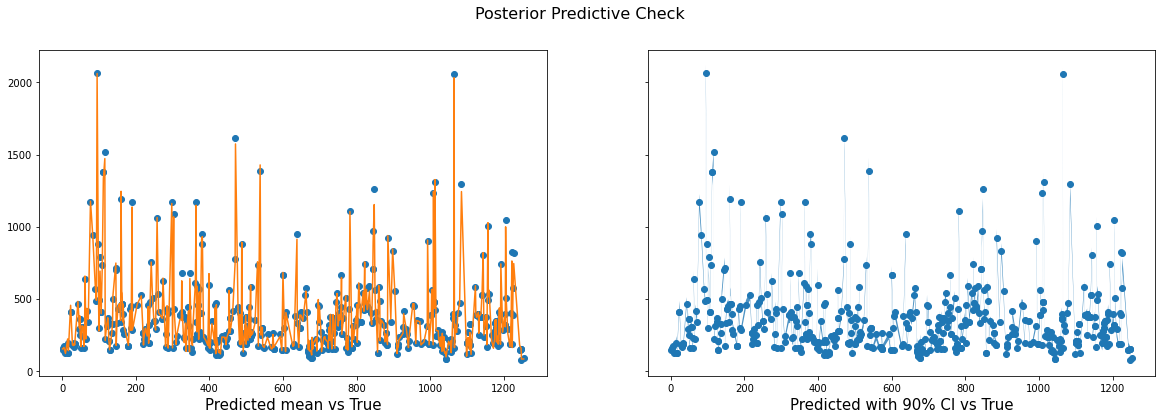

In [30]:
plot_posterior_predictive_check(obs, y_true, n_polls)